This notebook has been migrated based on the author's TF v1 [[code link]](https://github.com/ratschlab/dpsom/tree/master/som_vae).

So far, it is only available for image samples such as MNIST in fashion MNIST.

Some part of the SOM-VAE is implemented for sequence or time-series datasets, but the whole is before migration from TF v1.

### Requirements

* tensorflow-gpu $\ge$ 2.6

# Library

In [25]:
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn import metrics

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import functools
from tqdm import tqdm
from collections import Counter

gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0],True)

# Data loading

If you want to test with fashion MNIST, remark the line 1 and remove the hash the line 2

In [2]:
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')
# mnist = tf.keras.datasets.fashion_mnist.load_data() 

data_total = np.reshape(mnist[0][0], [-1,28*28])
maxx = np.reshape(np.amax(data_total, axis = -1), [-1,1])
print(maxx.shape)
data_total = np.reshape(data_total/maxx, [-1,28,28,1])
labels_total = mnist[0][1]

data_train, data_val, labels_train, labels_val = train_test_split(data_total, labels_total, test_size = 0.25, random_state = 42)
data_test = np.reshape(mnist[1][0], [-1,28*28])
maxx = np.reshape(np.amax(data_test, axis = -1), [-1,1])
data_test = np.reshape(data_test/maxx, [-1,28,28,1])
data_test.shape

data_val=data_test
labels_val=mnist[1][1]

(60000, 1)


# Batch generator

According to [the paper](https://arxiv.org/abs/1806.02199), they set up the data loader which generates non-time series data like time series.

In [3]:
def get_data_generator(time_series):
    """Creates a data generator for the training.
    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
            
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            indices = np.random.permutation(np.arange(len(images)))
            images = images[indices]
            labels = labels[indices]

            if not time_series:
                for i, image in enumerate(images):
                    start_image = image
                    end_image = images[np.random.choice(np.where(labels == (labels[i] + 1) % 10)[0])]
                    interpolation = interpolate_arrays(start_image, end_image, batch_size)
                    yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            else:
                for i in range(len(images)//batch_size):
                    yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator

def interpolate_arrays(arr1, arr2, num_steps=100, interpolation_length=0.3):
    """Interpolates linearly between two arrays over a given number of steps.
    The actual interpolation happens only across a fraction of those steps.
    Args:
        arr1 (np.array): The starting array for the interpolation.
        arr2 (np.array): The end array for the interpolation.
        num_steps (int): The length of the interpolation array along the newly created axis (default: 100).
        interpolation_length (float): The fraction of the steps across which the actual interpolation happens (default: 0.3).
    Returns:
        np.array: The final interpolated array of shape ([num_steps] + arr1.shape).
    """
    assert arr1.shape == arr2.shape, "The two arrays have to be of the same shape"
    start_steps = int(num_steps*interpolation_length)
    inter_steps = int(num_steps*((1-interpolation_length)/2))
    end_steps = num_steps - start_steps - inter_steps
    interpolation = np.zeros([inter_steps]+list(arr1.shape))
    arr_diff = arr2 - arr1
    for i in range(inter_steps):
        interpolation[i] = arr1 + (i/(inter_steps-1))*arr_diff
    start_arrays = np.concatenate([np.expand_dims(arr1, 0)] * start_steps)
    end_arrays = np.concatenate([np.expand_dims(arr2, 0)] * end_steps)
    final_array = np.concatenate((start_arrays, interpolation, end_arrays))
    return final_array


# SOM-VAE model

In [4]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,mnist=True):
        super().__init__()

        self.mnist = mnist
        
        if not self.mnist:
            self.L1 = tf.keras.layers.Dense(128, activation="relu")
            self.L2 = tf.keras.layers.Dense(256, activation="relu")
            self.L3 = tf.keras.layers.Dense(self.input_channels)
        else:
            self.flat_size = 7*7*256
            self.L1 = tf.keras.layers.Dense(self.flat_size)
            self.U1 = tf.keras.layers.UpSampling2D()
            self.C1 = tf.keras.layers.Conv2D(256,4,1,'same')
            self.U2 = tf.keras.layers.UpSampling2D()
            self.C2 = tf.keras.layers.Conv2D(1,4,1,'same')
        
    def __call__(self, x):
        
        if not self.mnist:
            h = self.L1(x) 
            h = self.L2(h) 
            x_hat = self.L3(h)
            
        else:
            h = tf.reshape(self.L1(x),(-1,7,7,256))
            u = self.U1(h)
            h = tf.nn.relu(self.C1(u))
            u = self.U2(h)
            x_hat = self.C2(u)
        return x_hat
                
                
class Encoder(tf.keras.layers.Layer):
    def __init__(self,mnist=True, latent_dim = None, input_channels = None):
        super().__init__()

        self.mnist = mnist
        
        if not self.mnist:
            assert input_channels != None, 'Please filled in input_channels in encoder argument of SOMVAE model'
            self.L1 = tf.keras.layers.Dense(256, activation="relu")
            self.L2 = tf.keras.layers.Dense(128, activation="relu")
            self.L3 = tf.keras.layers.Dense(input_channels)
        else:
            assert latent_dim != None, 'Please filled in latent_dim in encoder argument of SOMVAE model'
            self.C1 = tf.keras.layers.Conv2D(256,4,1,'same')
            self.D1 = tf.keras.layers.MaxPool2D()
            self.C2 = tf.keras.layers.Conv2D(256,4,1,'same')
            self.D2 = tf.keras.layers.MaxPool2D()
            self.L1 = tf.keras.layers.Dense(latent_dim)
            self.F = tf.keras.layers.Flatten()
            
    def __call__(self, x):
        
        if not self.mnist:
            h = self.L1(x) 
            h = self.L2(h) 
            x_hat = self.L3(h)
            
        else:
            h = tf.nn.relu(self.C1(x))
            d = self.D1(h)
            h = tf.nn.relu(self.C2(d))
            d = self.D2(h)
            x_hat = self.L1(self.F(d))
        return x_hat

    
                
class SOMVAE(tf.keras.Model):
    """Class for the SOM-VAE model"""

    def __init__(self, latent_dim=64, som_dim=[8,8], learning_rate=1e-4, decay_factor=0.95, decay_steps=1000,
            input_length=28, input_channels=28, alpha=1., beta=1., gamma=1., tau=1., mnist=True):
        super().__init__()
        """Initialization method for the SOM-VAE model object.
        
        Args:
            inputs (tf.Tensor): The input tensor for the model.
            latent_dim (int): The dimensionality of the latent embeddings (default: 64).
            som_dim (list): The dimensionality of the self-organizing map (default: [8,8]).
            learning_rate (float): The learning rate for the optimization (default: 1e-4).
            decay_factor (float): The factor for the learning rate decay (default: 0.95).
            decay_steps (int): The number of optimization steps before every learning rate
                decay (default: 1000).
            input_length (int): The length of the input data points (default: 28).
            input_channels (int): The number of channels of the input data points (default: 28).
            alpha (float): The weight for the commitment loss (default: 1.).
            beta (float): The weight for the SOM loss (default: 1.).
            gamma (float): The weight for the transition probability loss (default: 1.).
            tau (float): The weight for the smoothness loss (default: 1.).
            mnist (bool): Flag that tells the model if we are training in MNIST-like data (default: True).
        """
        self.latent_dim = latent_dim
        self.som_dim = som_dim
        self.learning_rate = learning_rate
        self.decay_factor = decay_factor
        self.decay_steps = decay_steps
        self.input_length = input_length
        self.input_channels = input_channels
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.mnist = mnist
        
        ## init variables & setting learnable params
        
        self.embeddings = tf.Variable(
            tf.random_normal_initializer()(self.som_dim + [self.latent_dim],),
            name = "embeddings"
        )
        
        transition_probabilities = tf.zeros(self.som_dim+self.som_dim)
        probabilities_positive = tf.exp(transition_probabilities)
        probabilities_summed = tf.reduce_sum(probabilities_positive, axis=[-1,-2], keepdims=True)
        self.transition_probabilities = tf.Variable(
            probabilities_positive / probabilities_summed,
            name="probabilities_raw"
        )
        
        self.encoder = Encoder(mnist,latent_dim =latent_dim)
        self.q_decoder = Decoder(mnist)
        self.e_decoder = Decoder(mnist)
        
        self.optimzier_setup()
        
    def param_setup(self, param_total, param_probs):
        self.param_total = param_total
        self.param_probs = param_probs
        
        
    
    
    def z_e_old(self,z_e):
        """Aggregates the encodings of the respective previous time steps."""
        z_e_old = tf.concat([z_e[0:1], z_e[:-1]], axis=0)
        return z_e_old
    
    
    def z_dist_flat(self,z_e):
        """Computes the distances between the encodings and the embeddings."""
        z_dist = tf.metrics.mean_squared_error(
            tf.expand_dims(tf.expand_dims(z_e, 1), 1), 
            tf.expand_dims(self.embeddings, 0)
        )
        z_dist_flat = tf.reshape(z_dist, [self.batch_size, -1])
        return z_dist_flat

    
    def k(self, z_dist_flat):
        """Picks the index of the closest embedding for every encoding, in evaluation 
           node it can be directly supplied as a placeholder."""
        k = tf.argmin(z_dist_flat, axis=-1)
        tf.summary.histogram("clusters", k)
        return k
    
    
    def z_q(self, k):
        """Aggregates the respective closest embedding for every encoding."""

        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)
        z_q = tf.gather_nd(self.embeddings, k_stacked)
        return z_q
    
    
    def z_q_neighbors(self, k, z_q):
        """Aggregates the respective neighbors in the SOM for every embedding in z_q."""
        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_stacked = tf.stack([k_1, k_2], axis=1)

        k1_not_top = tf.less(k_1, tf.constant(self.som_dim[0]-1, dtype=tf.int64))
        k1_not_bottom = tf.greater(k_1, tf.constant(0, dtype=tf.int64))
        k2_not_right = tf.less(k_2, tf.constant(self.som_dim[1]-1, dtype=tf.int64))
        k2_not_left = tf.greater(k_2, tf.constant(0, dtype=tf.int64))

        k1_up = tf.where(k1_not_top, tf.add(k_1, 1), k_1)
        k1_down = tf.where(k1_not_bottom, tf.subtract(k_1, 1), k_1)
        k2_right = tf.where(k2_not_right, tf.add(k_2, 1), k_2)
        k2_left = tf.where(k2_not_left, tf.subtract(k_2, 1), k_2)

        z_q_up = tf.where(
            tf.expand_dims(k1_not_top,-1), 
            tf.gather_nd(self.embeddings, tf.stack([k1_up, k_2], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        z_q_down = tf.where(
            tf.expand_dims(k1_not_bottom,-1),
            tf.gather_nd(self.embeddings, tf.stack([k1_down, k_2], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        z_q_right = tf.where(
            tf.expand_dims(k2_not_right,-1),
            tf.gather_nd(self.embeddings, tf.stack([k_1, k2_right], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )
        z_q_left = tf.where(
            tf.expand_dims(k2_not_left,-1),
            tf.gather_nd(self.embeddings, tf.stack([k_1, k2_left], axis=1)),
            tf.zeros([self.batch_size, self.latent_dim])
        )

        z_q_neighbors = tf.stack([z_q, z_q_up, z_q_down, z_q_right, z_q_left], axis=1)
        return z_q_neighbors
    
    
    def __call__(self,x,training=True):
        self.batch_size = x.shape[0]
        z_e = self.encoder(x)
        ze_dist = self.z_dist_flat(z_e)
        k = self.k(ze_dist)
        z_q = self.z_q(k)
        z_neighbors = self.z_q_neighbors(k, z_q)
        z_q_recon = self.q_decoder(z_q)
        z_e_recon = self.e_decoder(z_e)
        
        return dict(
            inputs = x,
            x_embedding = z_e, 
            x_reconstruction = z_e_recon,
            z_e_distance = ze_dist, 
            cluster_k = k, 
            e_embedding = z_q,
            neighbors = z_neighbors,
            q_reconstruction = z_q_recon,
        )
    
    
    def loss_reconstruction(self,x,ze,zq):
        """Computes the combined reconstruction loss for both reconstructions."""
        loss_rec_mse_zq = tf.losses.mean_squared_error(x, zq)
        loss_rec_mse_ze = tf.losses.mean_squared_error(x, ze)
        loss_rec_mse = tf.reduce_mean(loss_rec_mse_zq + loss_rec_mse_ze)
        tf.summary.scalar("loss_reconstruction", loss_rec_mse)
        return loss_rec_mse


    def loss_commit(self,ze,zq):
        """Computes the commitment loss."""
        loss_commit = tf.reduce_mean(
            tf.math.squared_difference(ze, zq)
        )
        tf.summary.scalar("loss_commit", loss_commit)
        return loss_commit


    def loss_som(self,ze,neighbors):
        """Computes the SOM loss."""
        loss_som = tf.reduce_mean(
            tf.math.squared_difference(
                tf.expand_dims(tf.stop_gradient(ze), axis=1), 
                neighbors
            )
        )
        tf.summary.scalar("loss_som", loss_som)
        return loss_som


    def loss_probabilities(self, k):
        """Computes the negative log likelihood loss for the transition probabilities."""
        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked = tf.stack([k_1_old, k_2_old, k_1, k_2], axis=1)
        transitions_all = tf.gather_nd(self.transition_probabilities, k_stacked)
        loss_probabilities = - tf.reduce_mean(tf.math.log(transitions_all))
        return loss_probabilities


    def loss_z_prob(self, k, z_dist_flat):
        """Computes the smoothness loss for the transitions given their probabilities."""
        k_1 = k // self.som_dim[1]
        k_2 = k % self.som_dim[1]
        k_1_old = tf.concat([k_1[0:1], k_1[:-1]], axis=0)
        k_2_old = tf.concat([k_2[0:1], k_2[:-1]], axis=0)
        k_stacked_old = tf.stack([k_1_old, k_2_old], axis=1)
        out_probabilities_old = tf.gather_nd(self.transition_probabilities, k_stacked_old)
        out_probabilities_flat = tf.reshape(out_probabilities_old, [self.batch_size, -1])
        weighted_z_dist_prob = tf.multiply(z_dist_flat, out_probabilities_flat)
        loss_z_prob = tf.reduce_mean(weighted_z_dist_prob)
        return loss_z_prob


    def loss(
        self, 
        inputs,
        x_embedding, 
        z_e_distance, 
        cluster_k, 
        e_embedding,
        neighbors,
        q_reconstruction,
        x_reconstruction,
    ):
        """Aggregates the loss terms into the total loss."""
        loss = (
            self.loss_reconstruction(inputs, x_reconstruction, q_reconstruction) + \
            self.alpha * self.loss_commit(x_embedding, e_embedding) + \
            self.beta * self.loss_som(x_embedding, neighbors) + \
            self.gamma * self.loss_probabilities(cluster_k) + \
            self.tau*self.loss_z_prob(cluster_k, z_e_distance)
        )
        loss_probs = self.gamma * self.loss_probabilities(cluster_k)
        tf.summary.scalar("loss", loss)
        tf.summary.scalar("probs", loss_probs)
        return dict(
            total = loss,
            probs = loss_probs
        )

    
    def optimzier_setup(self):
        self.optimizer_total = tf.keras.optimizers.Adam(
            tf.keras.optimizers.schedules.ExponentialDecay(
                self.learning_rate, 
                self.decay_steps, 
                self.decay_factor, 
                staircase=True
            )
        )
        self.optimizer_probs = tf.keras.optimizers.Adam(
            tf.keras.optimizers.schedules.ExponentialDecay(
                self.learning_rate*100, 
                self.decay_steps, 
                self.decay_factor, 
                staircase=True
            )
        )

    @tf.function
    def loss_update(self,x):
        
        with tf.GradientTape() as T_total, tf.GradientTape() as T_probs:
            outputs = self.__call__(x)
            loss = model.loss(**outputs)

            grads_total = T_total.gradient(loss['total'], self.param_total)
            grads_probs = T_probs.gradient(loss['probs'], self.param_probs)
        
            self.optimizer_total.apply_gradients(zip(grads_total, self.param_total))
            self.optimizer_probs.apply_gradients(zip(grads_probs, self.param_probs))
        
        return loss

# Learning start

In [5]:
model = SOMVAE()
model(data_total[:2])
model.param_setup(
    [i for i in model.trainable_variables if 'proba' not in i.name],
    [i for i in model.trainable_variables if 'proba' in i.name]
)

In [6]:
DG = get_data_generator(False)

batch_train = DG('train')
batch_valid = DG('val')

epochs = 10000
TQ = tqdm(range(epochs))
logger = dict(tr_loss = [], tr_probs = [], val_loss = [], val_probs = [])
for epoch in TQ:
    tr_x = next(batch_train) ; val_x = next(batch_valid)
    
    tr_loss = model.loss_update(tr_x)
    val_loss = model.loss(**model(val_x))
    
    logger['tr_loss'].append(tr_loss['total']) ; logger['tr_probs'].append(tr_loss['probs'])
    logger['val_loss'].append(val_loss['total']) ; logger['val_probs'].append(val_loss['probs'])
    TQ.set_description_str(f'Epoch : {epoch}')
    TQ.set_postfix_str(f"Tr L : {tr_loss['total']:.4} Val L : {val_loss['total']:.4} Tr L diff {tr_loss['total'] - tr_loss['probs']:.4}")


Epoch : 9999: 100%|██████████| 10000/10000 [07:54<00:00, 21.06it/s, Tr L : -2.813 Val L : -2.785 Tr L diff 0.04964]    


# Check loss

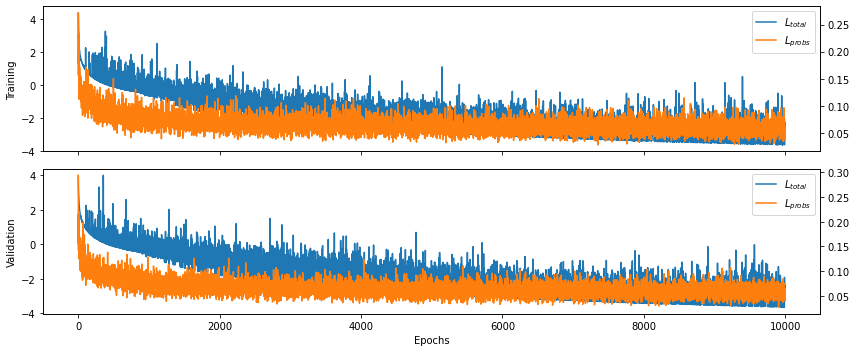

In [42]:
fig,ax = plt.subplots(2,1,figsize=(12,5),sharex=True)
tax0 = ax[0].twinx()
tax0.plot([i.numpy()-j.numpy() for i,j in zip(logger['tr_loss'],logger['tr_probs'])],'tab:orange')
ax[0].plot([i.numpy() for i in logger['tr_loss']])
ax[0].legend(
    handles = [
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:blue',label = r'$L_{total}$'),
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:orange',label = r'$L_{probs}$')
    ]
)
ax[0].set_ylabel('Training')   
    
#     [r'$L_{total}$','$L_{Probs}$'])


tax1 = ax[1].twinx()
tax1.plot([i.numpy()-j.numpy() for i,j in zip(logger['val_loss'],logger['val_probs'])],'tab:orange')
ax[1].plot([i.numpy() for i in logger['val_loss']])
ax[1].legend(
    handles = [
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:blue',label = r'$L_{total}$'),
        matplotlib.patches.mlines.Line2D([], [], color = 'tab:orange',label = r'$L_{probs}$')
    ]
)
ax[1].set_ylabel('Validation')   
ax[1].set_xlabel('Epochs')   
fig.tight_layout()

# Visualization

In [43]:
test_y = labels_val.copy()
test_x = data_val.copy()
som_dim = model.som_dim

test_loader = tf.data.Dataset.from_tensor_slices(test_x).batch(1000)

outputs = []
for b in test_loader:
    outputs.append(model(b))

Output = [o['cluster_k'] for o in outputs]
Output_dist = [o['z_e_distance'] for o in outputs]

Output_recon_e = [o['x_reconstruction'] for o in outputs]
Output_recon_q = [o['q_reconstruction'] for o in outputs]

dist_all = tf.concat(Output_dist,0).numpy()
k_all = tf.concat(Output,0).numpy()

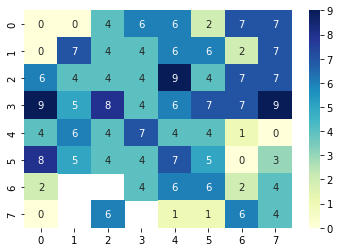

In [44]:


clust_matr1 = np.zeros(som_dim[0]*som_dim[1])
# ones = np.ones((len(k_all, (-1)))))

for i in range(som_dim[0]*som_dim[1]):
    
#     s1 = np.sum(test_y[np.where(k_all==i)]) / np.sum(ones[np.where(k_all==i)])
    try:
        s1 = Counter(test_y[np.where(k_all == i)]).most_common()[0][0]
        clust_matr1[i] = s1
    except:
        clust_matr1[i] = np.nan
    
clust_matr1 = np.reshape(clust_matr1, (som_dim[0],som_dim[1]))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu", vmin=0,vmax=9, annot=True, fmt=".0f")
plt.show()

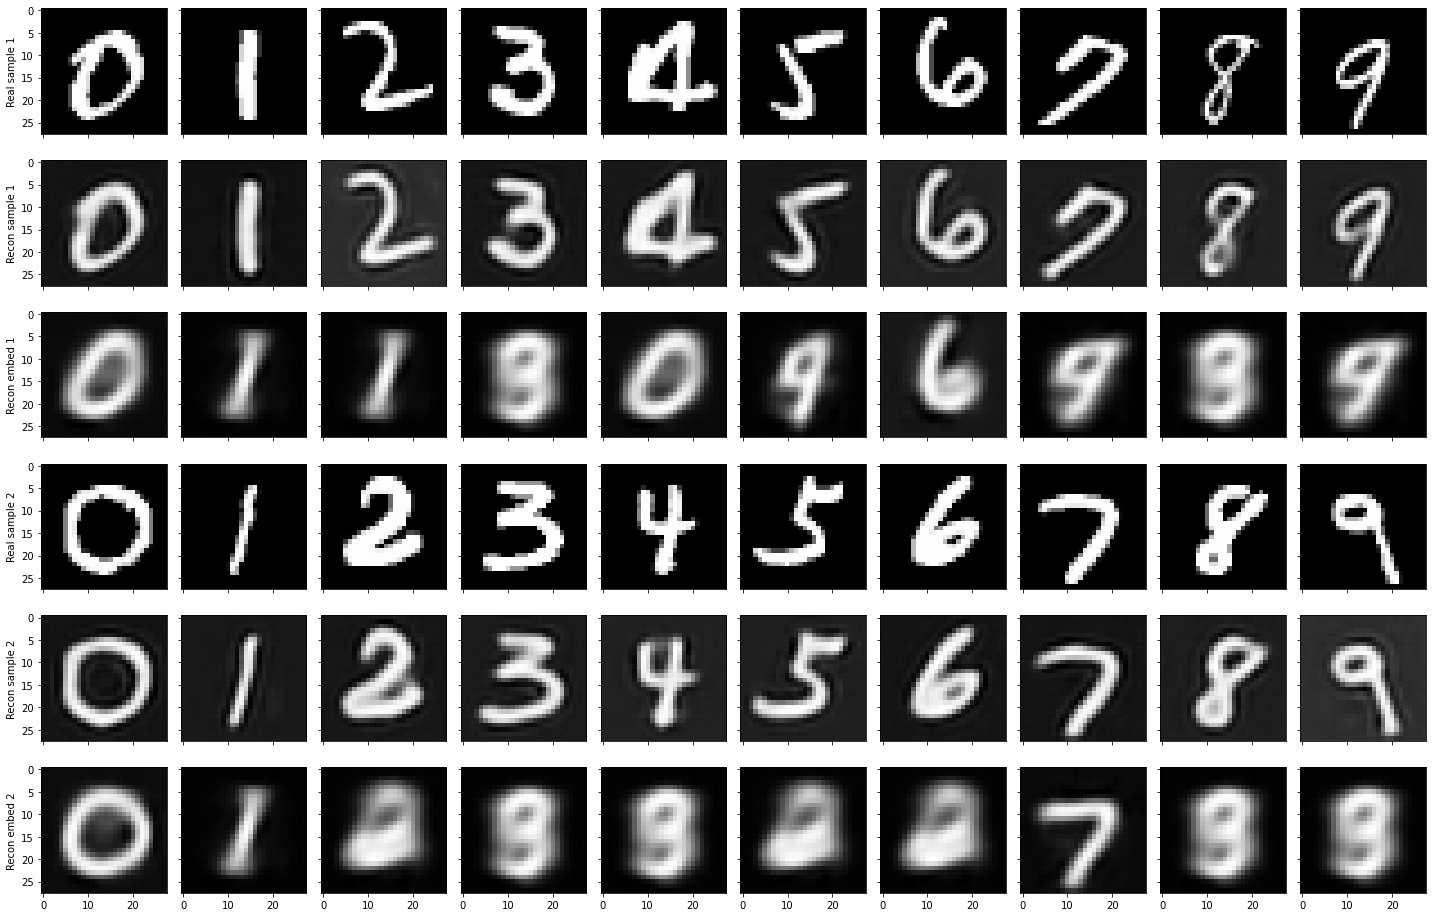

In [48]:
y_test = labels_val.copy()
x_test = data_val.copy()

fig,ax = plt.subplots(6,10,figsize=(20,13),sharex=True,sharey=True)

for number in range(10):
# number = 0
    test_idx = y_test == number
    spec_x_test = x_test[test_idx]
    spec_y_test = y_test[test_idx]
    
    sample_x_test = spec_x_test[np.random.randint(0,spec_x_test.shape[0])][np.newaxis, ...]
    output = model(sample_x_test)
    
    ax[0][number].imshow(output['inputs'][0, ...],cmap='Greys_r')
    ax[1][number].imshow(output['x_reconstruction'][0, ...],cmap='Greys_r')
    ax[2][number].imshow(output['q_reconstruction'][0, ...],cmap='Greys_r')
    
    
    sample_x_test = spec_x_test[np.random.randint(0,spec_x_test.shape[0])][np.newaxis, ...]
    output = model(sample_x_test)
    
    ax[3][number].imshow(output['inputs'][0, ...],cmap='Greys_r')
    ax[4][number].imshow(output['x_reconstruction'][0, ...],cmap='Greys_r')
    ax[5][number].imshow(output['q_reconstruction'][0, ...],cmap='Greys_r')
    
ax[0][0].set_ylabel('Real sample 1')
ax[1][0].set_ylabel('Recon sample 1')
ax[2][0].set_ylabel('Recon embed 1')

ax[3][0].set_ylabel('Real sample 2')
ax[4][0].set_ylabel('Recon sample 2')
ax[5][0].set_ylabel('Recon embed 2')

fig.tight_layout()